# Building a custom object detection model with Resnet FRCNN as backbone

In [28]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torch.nn as nn
import torchvision.models.detection as detection
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torch import optim
# %load_ext tensorboard
# import tensorflow as tf
# import datetime
# from tensorflow import keras
# from tensorflow.keras.callbacks import TensorBoard
from LoadingBMWDataset import CustomObjectDetectionDataset
import matplotlib.pyplot as plt
import numpy as np
import torch.onnx

torch.cuda.empty_cache()
torch.cuda.is_available()

True

In [10]:
# Specify the image and annotation directories
img_dir = '/home/wgt/Desktop/InMind Academy/AI_Track/Amazing_Project/inmind_amazing_project/data/Training/images'
annotation_dir = '/home/wgt/Desktop/InMind Academy/AI_Track/Amazing_Project/inmind_amazing_project/data/Training/labels/json'

# Create a CustomObjectDetectionDataset object
dataset = CustomObjectDetectionDataset(img_dir, annotation_dir)

dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = dataset_size - train_size

train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])


# The custom collate function will be used to stack the images and targets into a batch
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    return images, targets

# When creating the DataLoaders for training and validation, pass the custom collate function
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Ensring that the dataset is loaded correctly
print(type(dataset[0][0]))

<class 'torch.Tensor'>


In [11]:
# Defining the custom model function to get the pre-trained Faster R-CNN model
def get_custom_model(num_classes):
    # Loading a pre-trained Faster R-CNN model
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Getting the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Creating the custom layers
    # Note: It's crucial to match the input size of the first custom layer to 'in_features'
    custom_head_layers = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
    )

    # Extending the box predictor to include custom layers before final classification and regression layers
    model.roi_heads.box_predictor = FastRCNNPredictor(1024, num_classes)
    
    return model

# Using the function to get the customized model
num_classes = 7 + 1  # 7 classes + background
model = get_custom_model(num_classes)


/home/wgt/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wgt/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Creating the optimizer based on the pre-trained model parameters and the modified custom layers
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

# Moving the model to the device
model.to(device)

cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Selecting the parameters to be optimized
params = [p for p in model.parameters() if p.requires_grad]

# Defining the optimizer, being the Stochastic Gradient Descent (SGD)
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

writer = SummaryWriter('runs/logs')

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0
    
    # Training phase
    for i, (images, targets) in enumerate(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        train_loss += losses.item()
        losses.backward()
        optimizer.step()

        if i % 10 == 0:  # Log every 10 batches
            # Log the training loss
            writer.add_scalar('Training loss', losses.item(), epoch * len(train_loader) + i)

            # Log model parameters and gradients
            for name, param in model.named_parameters():
                if param.grad is not None:
                    writer.add_histogram(f'{name}.grad', param.grad, epoch * len(train_loader) + i)
                writer.add_histogram(name, param, epoch * len(train_loader) + i)

    avg_train_loss = train_loss / len(train_loader)
    print(f'Epoch: {epoch}, Training Loss: {avg_train_loss:.4f}')

    # Validation phase
    val_loss = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for images, targets in validation_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    avg_val_loss = val_loss / len(validation_loader)
    print(f'Epoch: {epoch}, Validation Loss: {avg_val_loss:.4f}')
    writer.add_scalar('Validation loss', avg_val_loss, epoch)

writer.close()

## Saving the model's parameters for future use

In [6]:
# Saving the model's state dictionary
torch.save(model.state_dict(), 'customResnet50FasterRCNN.pth')


In [14]:
########################################################################################################
# To reload the model with the last saved state dictionary (or parameters), run the following code:    #
#                                                                                                      #
#                                                                                                      #
# Recreating the model instance to ensure the same architecture is used                                #
model = get_custom_model(num_classes)

# Loading the saved state dictionary into the model to pick up training from where we left off
model.load_state_dict(torch.load('/home/wgt/Desktop/customResnet50FasterRCNN.pth'))

# Setting the device to be used for training                                                           #
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#                                                                                                      #
# Move the model to the desired device                                                                 #
model.to(device)
########################################################################################################

/home/wgt/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wgt/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Evaluating the model

In [15]:
test_img_dir = '/home/wgt/Desktop/InMind Academy/AI_Track/Amazing_Project/inmind_amazing_project/data/Testing/images'
test_annotation_dir = '/home/wgt/Desktop/InMind Academy/AI_Track/Amazing_Project/inmind_amazing_project/data/Testing/labels/json_modified'

# Initialize the dataset
test_dataset = CustomObjectDetectionDataset(test_img_dir, test_annotation_dir)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


In [17]:
def run_inference(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    results = []
    with torch.no_grad():  # No need to calculate gradients
        for images, _ in data_loader:  # Assuming the DataLoader returns a tuple of images and targets
            images = [img.to(device) for img in images]  # Move each image in the batch to the device
            predictions = model(images)  # Get model predictions
            results.extend(predictions)
    return results

# Get predictions for the test dataset
predictions = run_inference(model, test_loader, device)


No boxes found for image: 117.jpg


/home/wgt/Desktop/InMind Academy/AI_Track/Amazing_Project/inmind_amazing_project/src/LoadingBMWDataset.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target['labels'] = torch.tensor(labels, dtype=torch.int64)


No boxes found for image: 200.jpg
No boxes found for image: 102.jpg
No boxes found for image: 334.jpg
No boxes found for image: 702.jpg
No boxes found for image: 213.jpg
No boxes found for image: 219.jpg
No boxes found for image: 10.jpg
No boxes found for image: 925.jpg
No boxes found for image: 105.jpg
No boxes found for image: 989.jpg
No boxes found for image: 732.jpg
No boxes found for image: 991.jpg
No boxes found for image: 589.jpg


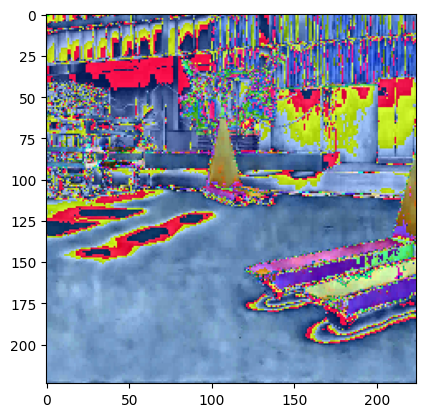

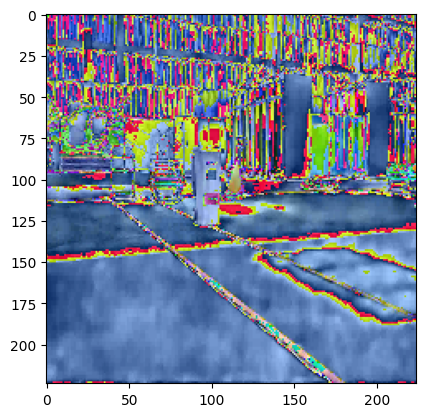

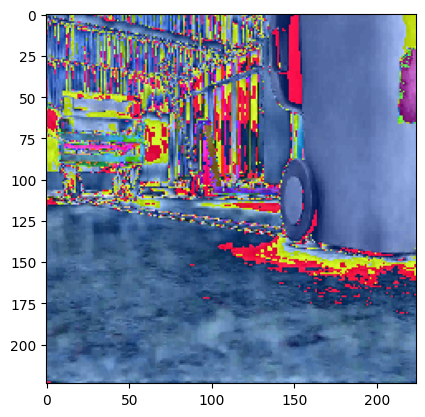

In [33]:
def visualize_predictions(images, predictions):
    for img, pred in zip(images, predictions):
        img = img.cpu().numpy().transpose(1, 2, 0)
        img = (img * 255).astype(np.uint8)
        
        for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
            cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
            cv2.putText(img, f'{label}: {score:.2f}', (int(box[0]), int(box[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
        
        plt.imshow(img)
        plt.show()

# Assuming 'images' is a batch of images from your DataLoader
visualize_predictions(images, predictions)


In [24]:
def bbox_iou(box1, box2):

    # Calculate the coordinates of the intersection rectangle
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    # Compute the area of intersection
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(box1Area + box2Area - interArea)

    return iou


In [21]:
def calculate_metrics(predictions, ground_truths, iou_threshold=0.5):
    
    # Placeholder for true positives, false positives, and the number of ground truths
    tp = 0
    fp = 0
    n_ground_truths = 0

    for pred, gt in zip(predictions, ground_truths):
        gt_boxes = gt['boxes']
        gt_labels = gt['labels']
        pred_boxes = pred['boxes']
        pred_labels = pred['labels']
        pred_scores = pred['scores']

        n_ground_truths += len(gt_boxes)

        for i, p_box in enumerate(pred_boxes):
            # Sort predictions by scores (highest first)
            sorted_indices = np.argsort(-np.array(pred_scores))
            p_box = pred_boxes[sorted_indices[i]]
            p_label = pred_labels[sorted_indices[i]]

            best_iou = 0
            for j, gt_box in enumerate(gt_boxes):
                iou = bbox_iou(p_box, gt_box)
                if iou > best_iou and p_label == gt_labels[j]:
                    best_iou = iou
                    matched_gt_box = j

            if best_iou > iou_threshold:
                tp += 1
                # Remove the matched ground truth box
                gt_boxes = np.delete(gt_boxes, matched_gt_box, 0)
                gt_labels = np.delete(gt_labels, matched_gt_box)
            else:
                fp += 1

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / n_ground_truths if n_ground_truths > 0 else 0
    # Assuming binary classification for simplification; for multi-class, calculate AP for each class and take mean
    metrics = {'Precision': precision, 'Recall': recall, 'mAP': (precision + recall) / 2}

    return metrics


In [25]:
def adjust_tensors(data):
    if isinstance(data, torch.Tensor):
        return data.cpu()
    elif isinstance(data, dict):
        return {k: adjust_tensors(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [adjust_tensors(v) for v in data]
    return data

predictions_cpu = [adjust_tensors(pred) for pred in predictions]
ground_truths_cpu = [adjust_tensors(gt) for gt in ground_truths]

# Now call calculate_metrics with the adjusted data
metrics = calculate_metrics(predictions_cpu, ground_truths_cpu, iou_threshold=0.5)


In [26]:
print(metrics)

{'Precision': 0.1361067568682452, 'Recall': 0.9889105349917579, 'mAP': 0.5625086459300015}


## Exporting the model to ONNX

In [27]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [31]:
batch_size = 1
channels = 3
height = 224
width = 224
example_input = torch.randn(batch_size, channels, height, width, device=device)

In [32]:
onnx_model_path = "/home/wgt/Desktop/customResNet.onnx"
torch.onnx.export(model,               # model being run
                  example_input,       # model input (or a tuple for multiple inputs)
                  onnx_model_path,     # where to save the model
                  export_params=True,  # store the trained parameter weights inside the model file
                  opset_version=11,    # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names=['input'],   # the model's input names
                  output_names=['output'],  # the model's output names
                  dynamic_axes={'input': {0: 'batch_size'},    # variable length axes
                                'output': {0: 'batch_size'}})

/home/wgt/.local/lib/python3.8/site-packages/torch/nn/functional.py:3982: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.floor((input.size(i + 2).float() * torch.tensor(scale_factors[i], dtype=torch.float32)).float()))
/home/wgt/.local/lib/python3.8/site-packages/torchvision/ops/boxes.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
/home/wgt/.local/lib/python3.8/site-packages/torchvision/ops/boxes.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sour